<a href="https://colab.research.google.com/github/Kinds-of-Intelligence-CFI/measurement-layout-tutorial/blob/main/tutorial-notebooks/5_1_Learning_the_capabilities_of_LLMs_Addition_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning the Capabilities of LLMs to Perform Addition

Here, we construct a measurement layout for the Addition dataset (not yet public).

The dataset includes the instance-level performance on simple addition tasks of 10 LLMs: `GPT-3 Ada`, `GPT-3 Babbage`, `GPT-3 Curie`, `GPT-3 Davinci`, `text-davinci-001`, `text-davinci-002`, `text-davinci-003`, `GPT-3.5-turbo`, `GPT-4-0314`, and `GPT-4-0613`.

The dataset contains the following columns:

- `instance_id`: ID of an instance.
- `template_id`: ID of a prompt template. Each addition prompt was phrased in 15 different ways.
- `llm`: The large language model tested.
- `prompt`: The actual prompt.
- `response`: The LLM's response.
- `summand1`: The first number to be added.
- `summand2`: The second number to be added.
- `target`: The correct sum of the two summands.
- `digits1`: The number of digits in the first summand.
- `digits2`: The number of digits in the second summand.
- `min_digits`: $min(digits_1, digits_2)$, i.e., the number of digits in the smaller summand.
- `harm_mean`: $2 / (1/digits_1 + 1/digits_2)$, i.e., the harmonic mean of the number of digits in the two summands.
- `art_mean`: $(digits_1 + digits_2) / 2$, i.e., the arithmetic mean of the number of digits in the two summands.
- `max_digits`: $max(digits_1, digits_2)$, i.e., the number of digits in the larger summand.
- `carry`: The number of carrying operations required to add the two numbers.
- `success`: Indicates whether the response is correct (1) or incorrect (0).

In [1]:
import warnings

# Filter warnings for the specific library you want to suppress
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pymc as pm
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from google.colab import files

%load_ext autoreload
%autoreload 2

print(f"Running on PyMC v{pm.__version__}") #Note, colab imports an older version of PyMC by default. This won't cause problems for this tutorial, but may do if you use a different backend (e.g., gpu) and a jax/numpyro sampler. In which case, run `!pip install 'pymc>5.9' --quiet`

Running on PyMC v5.7.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Define utility functions

In [3]:
# logistic function with standard parameters
def logistic(x, x0=0, k=1):
    """
    Generalized logistic function allowing to specify the center of the curve and the steepness.
    See at https://en.wikipedia.org/wiki/Generalised_logistic_function

    One can also include other parameters:
    :math:`y(x) = \frac{K}{(1+e^{-Bx})^{1/\nu}}`
    where K can be set so that the maximum value is 1 even if the domain of the parameter is bounded and
    $\nu$ dictates close to which asymptot maximum growth occurs. For now we keep them both fixed at 1

    :param x: The x value
    :param x0: The function is centred on x0 (where the probability is 0.5)
    :param k: The slope (steepness) is k

    """
    # notice that you cannot use scipy advanced math here as this will be used by pymc. This may not be the most
    # efficient implementation
    return 1 / (1 + np.exp(-k * (x - x0)))


# the margin is just the subtraction, assuming ability and demand are *in the same scale*
def margin(ability, demand):
    return ability - demand


def brierDecomp(preds, outs):
    brier = 1 / len(preds) * sum((preds - outs) ** 2)
    ## bin predictions
    bins = np.linspace(0, 1, 11)
    binCenters = (bins[:-1] + bins[1:]) / 2
    binPredInds = np.digitize(preds, binCenters)
    binnedPreds = bins[binPredInds]

    binTrueFreqs = np.zeros(10)
    binPredFreqs = np.zeros(10)
    binCounts = np.zeros(10)

    for i in range(10):
        idx = (preds >= bins[i]) & (preds < bins[i + 1])

        binTrueFreqs[i] = np.sum(outs[idx]) / np.sum(idx) if np.sum(idx) > 0 else 0
        # print(np.sum(outs[idx]), np.sum(idx), binTrueFreqs[i])
        binPredFreqs[i] = np.mean(preds[idx]) if np.sum(idx) > 0 else 0
        binCounts[i] = np.sum(idx)

    calibration = np.sum(binCounts * (binTrueFreqs - binPredFreqs) ** 2) / np.sum(binCounts) if np.sum(
        binCounts) > 0 else 0
    refinement = np.sum(binCounts * (binTrueFreqs * (1 - binTrueFreqs))) / np.sum(binCounts) if np.sum(
        binCounts) > 0 else 0
    # Compute refinement component
    # refinement = brier - calibration
    return brier, calibration, refinement


# define generic function to evaluate a predictive method (such as LogisticRegression)
def evaluate_predictive_method(df_train, df_test, features_cols, response_col, predictive_method=LogisticRegression,
                               return_trained_method=False, compute_accuracy=False, trained_method=None, **kwargs):
    if len(features_cols) == 1 and type(df_train[features_cols[0]].iloc[0]) == np.ndarray:
        # if the features are already a numpy array, then don't convert to numpy array
        features_train = np.array(list(df_train[features_cols[0]].values))
        features_test = np.array(list(df_test[features_cols[0]].values))
    else:
        # traditional one
        features_train = df_train[features_cols].to_numpy()
        features_test = df_test[features_cols].to_numpy()

    if response_col in features_cols:
        raise ValueError("response_col must not be in features_cols")

    if trained_method is not None:
        method_instance = trained_method
    else:
        # fit logistic regression using training features and the agent col as response
        method_instance = predictive_method(**kwargs)
        method_instance.fit(features_train, df_train[response_col])

    # evaluate on the test set
    y_pred = method_instance.predict_proba(features_test)[:, 1]

    BrierScore, Calibration, Refinement = brierDecomp(y_pred, df_test[response_col])
    # compute the ROC AUC using sklearn
    if not (sum(df_test[response_col]) == 0 or sum(df_test[response_col]) == len(df_test)):
        roc_auc = roc_auc_score(df_test[response_col], y_pred)
    else:
        roc_auc = np.nan

    if compute_accuracy:
        # compute accuracy by thresholding at 0.5
        y_pred_binary = y_pred > 0.5
        accuracy = np.mean(y_pred_binary == df_test[response_col])

    return_list = [BrierScore, Calibration, Refinement, roc_auc]
    if compute_accuracy:
        return_list.append(accuracy)
    if return_trained_method:
        return_list.append(method_instance)
    return return_list

## Load and explore the Addition dataset

In [4]:
addition_data = pd.read_pickle('/content/Addition_data.pkl')

In [5]:
addition_data

,instance_id,template_id,llm,prompt,response,summand1,summand2,target,digits1,digits2,min_digits,harm_mean,art_mean,max_digits,carry,success
0,1,1,GPT-3 Ada,656050998910983832047 + 4871137 =,0x0000000000000001 + 4907811 = 0x000000000000...,656050998910983832047,4871137,656050998910988703184,21,7,7,10.500000,14.0,21,3.0,0
1,1,2,GPT-3 Ada,656050998910983832047 plus 4871137 equals,0.0017285858585858585858585858585858585858585...,656050998910983832047,4871137,656050998910988703184,21,7,7,10.500000,14.0,21,3.0,0
2,1,3,GPT-3 Ada,The sum of 656050998910983832047 and 4871137 is,not a number.\n\nThe sum of 65605099891098383...,656050998910983832047,4871137,656050998910988703184,21,7,7,10.500000,14.0,21,3.0,0
3,1,4,GPT-3 Ada,Add: 656050998910983832047 + 4871137 =,0x656050998910983832047\n\n+\n\n+#: ../src/te...,656050998910983832047,4871137,656050998910988703184,21,7,7,10.500000,14.0,21,3.0,0
4,1,5,GPT-3 Ada,Add 656050998910983832047 and 4871137 and writ...,\n\nThe result is a list of the number of elem...,656050998910983832047,4871137,656050998910988703184,21,7,7,10.500000,14.0,21,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471295,3142,11,GPT-4-0613,If you have 9299491479934776556741953510079620...,9299491479934776556741953510079620309265188146...,9299491479934776556741953510079620235932207865...,734312979294782227546313411365712009030,9299491479934849988039882988302374867273344437...,53,39,39,44.934783,46.0,53,14.0,0
471296,3142,12,GPT-4-0613,How much is 9299491479934776556741953510079620...,9299491479934776556741953510079620235932207865...,9299491479934776556741953510079620235932207865...,734312979294782227546313411365712009030,9299491479934849988039882988302374867273344437...,53,39,39,44.934783,46.0,53,14.0,0
471297,3142,13,GPT-4-0613,9299491479934776556741953510079620235932207865...,9299491479934776556741953510079620235932207865...,9299491479934776556741953510079620235932207865...,734312979294782227546313411365712009030,9299491479934849988039882988302374867273344437...,53,39,39,44.934783,46.0,53,14.0,0
471298,3142,14,GPT-4-0613,Find the value of x + y when x=929949147993477...,x + y = 92994914799347765567419535100796202359...,9299491479934776556741953510079620235932207865...,734312979294782227546313411365712009030,9299491479934849988039882988302374867273344437...,53,39,39,44.934783,46.0,53,14.0,0


In [6]:
addition_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471300 entries, 0 to 471299
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   instance_id  471300 non-null  int64  
 1   template_id  471300 non-null  int64  
 2   llm          471300 non-null  object 
 3   prompt       471300 non-null  object 
 4   response     471294 non-null  object 
 5   summand1     471300 non-null  object 
 6   summand2     471300 non-null  object 
 7   target       471300 non-null  object 
 8   digits1      471300 non-null  int64  
 9   digits2      471300 non-null  int64  
 10  min_digits   471300 non-null  int64  
 11  harm_mean    471300 non-null  float64
 12  art_mean     471300 non-null  float64
 13  max_digits   471300 non-null  int64  
 14  carry        471300 non-null  float64
 15  success      471300 non-null  int64  
dtypes: float64(3), int64(7), object(6)
memory usage: 57.5+ MB


In [7]:
addition_data.describe()

,instance_id,template_id,digits1,digits2,min_digits,harm_mean,art_mean,max_digits,carry,success
count,471300.000000,471300.000000,471300.000000,471300.000000,471300.000000,471300.000000,471300.000000,471300.000000,471300.000000,471300.000000
mean,1524.160789,8.000000,39.109484,38.244112,19.305538,26.447418,38.676798,58.048059,9.617441,0.048112
std,906.820751,4.320498,27.090303,26.295428,11.798564,13.926740,13.559694,23.151875,6.368646,0.214002
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.333333,1.500000,2.000000,0.000000,0.000000
25%,726.000000,4.000000,17.000000,17.000000,9.000000,14.476190,29.500000,41.000000,4.000000,0.000000
50%,1512.000000,8.000000,33.000000,33.000000,18.000000,26.492036,40.500000,58.000000,9.000000,0.000000
75%,2298.000000,12.000000,59.000000,57.000000,29.000000,38.634146,49.000000,77.000000,14.000000,0.000000
max,3151.000000,15.000000,100.000000,100.000000,50.000000,50.000000,66.500000,100.000000,37.000000,1.000000


In [8]:
addition_data.describe(include='object')

,llm,prompt,response,summand1,summand2,target
count,471300,471300,471294,471300,471300,471300
unique,10,47130,367493,2639,2589,3142
top,GPT-3 Ada,656050998910983832047 + 4871137 =,\n\n+\n\n+\n\n+\n\n+\n\n+\n\n+\n\n+\n\n+\n\n+\...,8,9,656050998910988703184
freq,47130,10,3698,900,1350,150


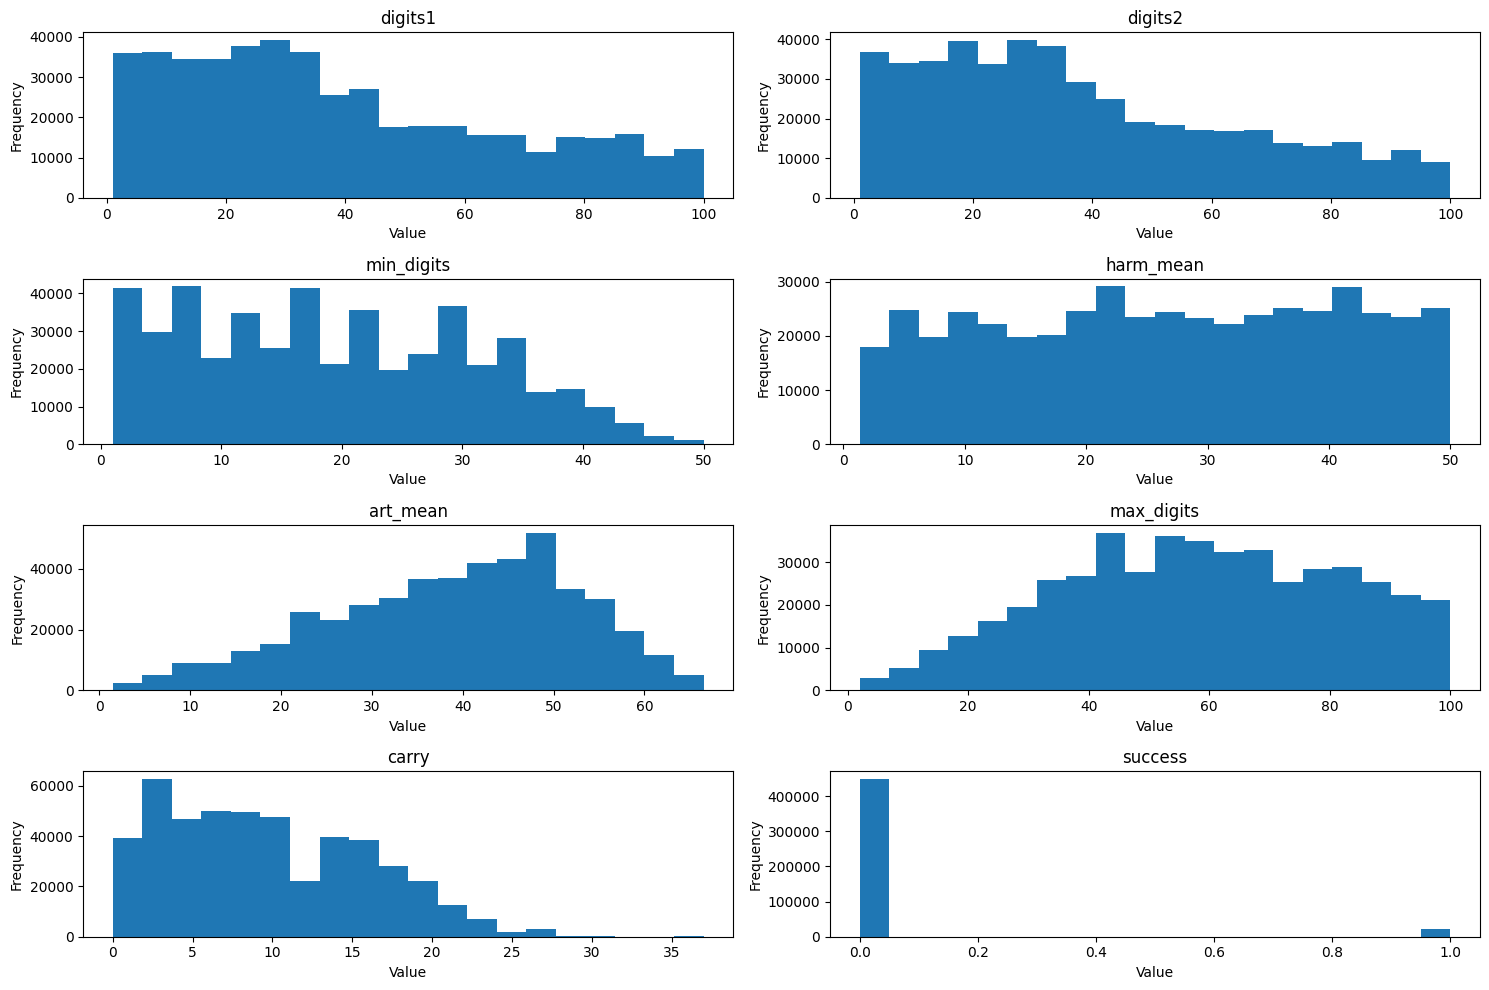

In [9]:
columns_to_plot = ['digits1', 'digits2', 'min_digits', 'harm_mean', 'art_mean', 'max_digits', 'carry', 'success']
n_rows = 4
n_cols = 2

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 10))

for i, column in enumerate(columns_to_plot):
    ax = axes[i//n_cols, i%n_cols]
    ax.hist(addition_data[column], bins=20)
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [10]:
addition_data['llm'].unique()

array(['GPT-3 Ada', 'GPT-3 Babbage', 'GPT-3 Curie', 'GPT-3 Davinci',
       'text-davinci-001', 'text-davinci-002', 'text-davinci-003',
       'GPT-4-0314', 'GPT-3.5-turbo', 'GPT-4-0613'], dtype=object)

In [11]:
addition_data.groupby('llm')['success'].value_counts().unstack(fill_value=0) #plot(kind='bar')

success,0,1
llm,,
GPT-3 Ada,47113,17
GPT-3 Babbage,47066,64
GPT-3 Curie,47040,90
GPT-3 Davinci,46974,156
GPT-3.5-turbo,40584,6546
GPT-4-0314,41619,5511
GPT-4-0613,41857,5273
text-davinci-001,46594,536
text-davinci-002,44858,2272


Plot aggregate accuracy for each LLM on Addition data set

<ipython-input-12-3e65d7579b74>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='LLM', y='Accuracy', data=accuracy_data_sorted, palette='viridis')
<ipython-input-12-3e65d7579b74>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


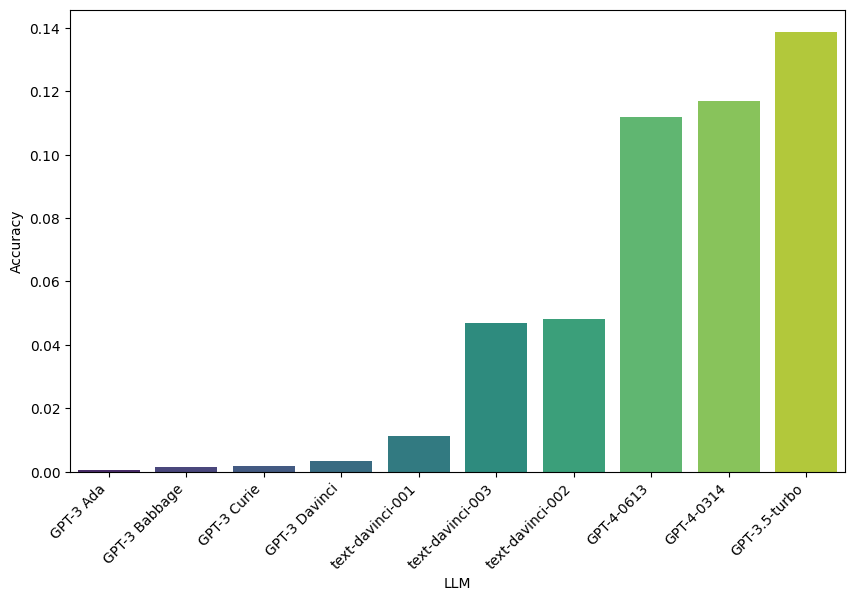

In [12]:
accuracy_data = addition_data.groupby('llm')['success'].mean().reset_index()

accuracy_data.rename(columns={'llm': 'LLM', 'success': 'Accuracy'}, inplace=True)
accuracy_data_sorted = accuracy_data.sort_values(by='Accuracy', ascending=True)

plt.figure(figsize=(10,6))
ax = sns.barplot(x='LLM', y='Accuracy', data=accuracy_data_sorted, palette='viridis')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

Plot correlations between the features and success on the task

In [13]:
feats = ['digits1', 'digits2', 'min_digits', 'harm_mean', 'art_mean', 'max_digits', 'carry', 'success']
llms = addition_data['llm'].unique()

# do this for each llm
correlation_df = pd.DataFrame()
all_corrs = {}
for llm in llms:
    corr = addition_data[addition_data['llm'] == llm][feats].corr()
    all_corrs[llm] = corr
    #print(corr["sensical_levels"]["rung"])
    correlation_df = pd.concat([correlation_df, pd.DataFrame({"llm": llm, "digits1": corr["success"]["digits1"], "digits2": corr["success"]["digits2"],\
                                                              "min_digits": corr["success"]["min_digits"],"harm_mean":corr["success"]["harm_mean"],\
                                                               "art_mean": corr["success"]["art_mean"],"max_digits": corr["success"]["max_digits"],\
                                                              "carry": corr["success"]["carry"]

                                                            }, index=[0])])

In [14]:
correlation_df

,llm,digits1,digits2,min_digits,harm_mean,art_mean,max_digits,carry
0,GPT-3 Ada,-0.018679,-0.013647,-0.029472,-0.033548,-0.031891,-0.022337,-0.028686
0,GPT-3 Babbage,-0.021843,-0.039104,-0.057212,-0.065198,-0.059736,-0.040816,-0.055686
0,GPT-3 Curie,-0.033349,-0.044155,-0.067864,-0.077525,-0.076126,-0.054587,-0.065596
0,GPT-3 Davinci,-0.036164,-0.065017,-0.088596,-0.101038,-0.099168,-0.071012,-0.084125
0,text-davinci-001,-0.038415,-0.119602,-0.162981,-0.185054,-0.154342,-0.097734,-0.154270
0,text-davinci-002,-0.081820,-0.152555,-0.329022,-0.368421,-0.229652,-0.101332,-0.303680
0,text-davinci-003,-0.035655,-0.199409,-0.327540,-0.367861,-0.228967,-0.101286,-0.302824
0,GPT-4-0314,-0.139222,-0.224036,-0.441993,-0.504143,-0.356302,-0.192115,-0.405705
0,GPT-3.5-turbo,-0.159572,-0.255769,-0.503067,-0.557548,-0.407399,-0.220843,-0.462689
0,GPT-4-0613,-0.166903,-0.221421,-0.420131,-0.489253,-0.381418,-0.232676,-0.383193


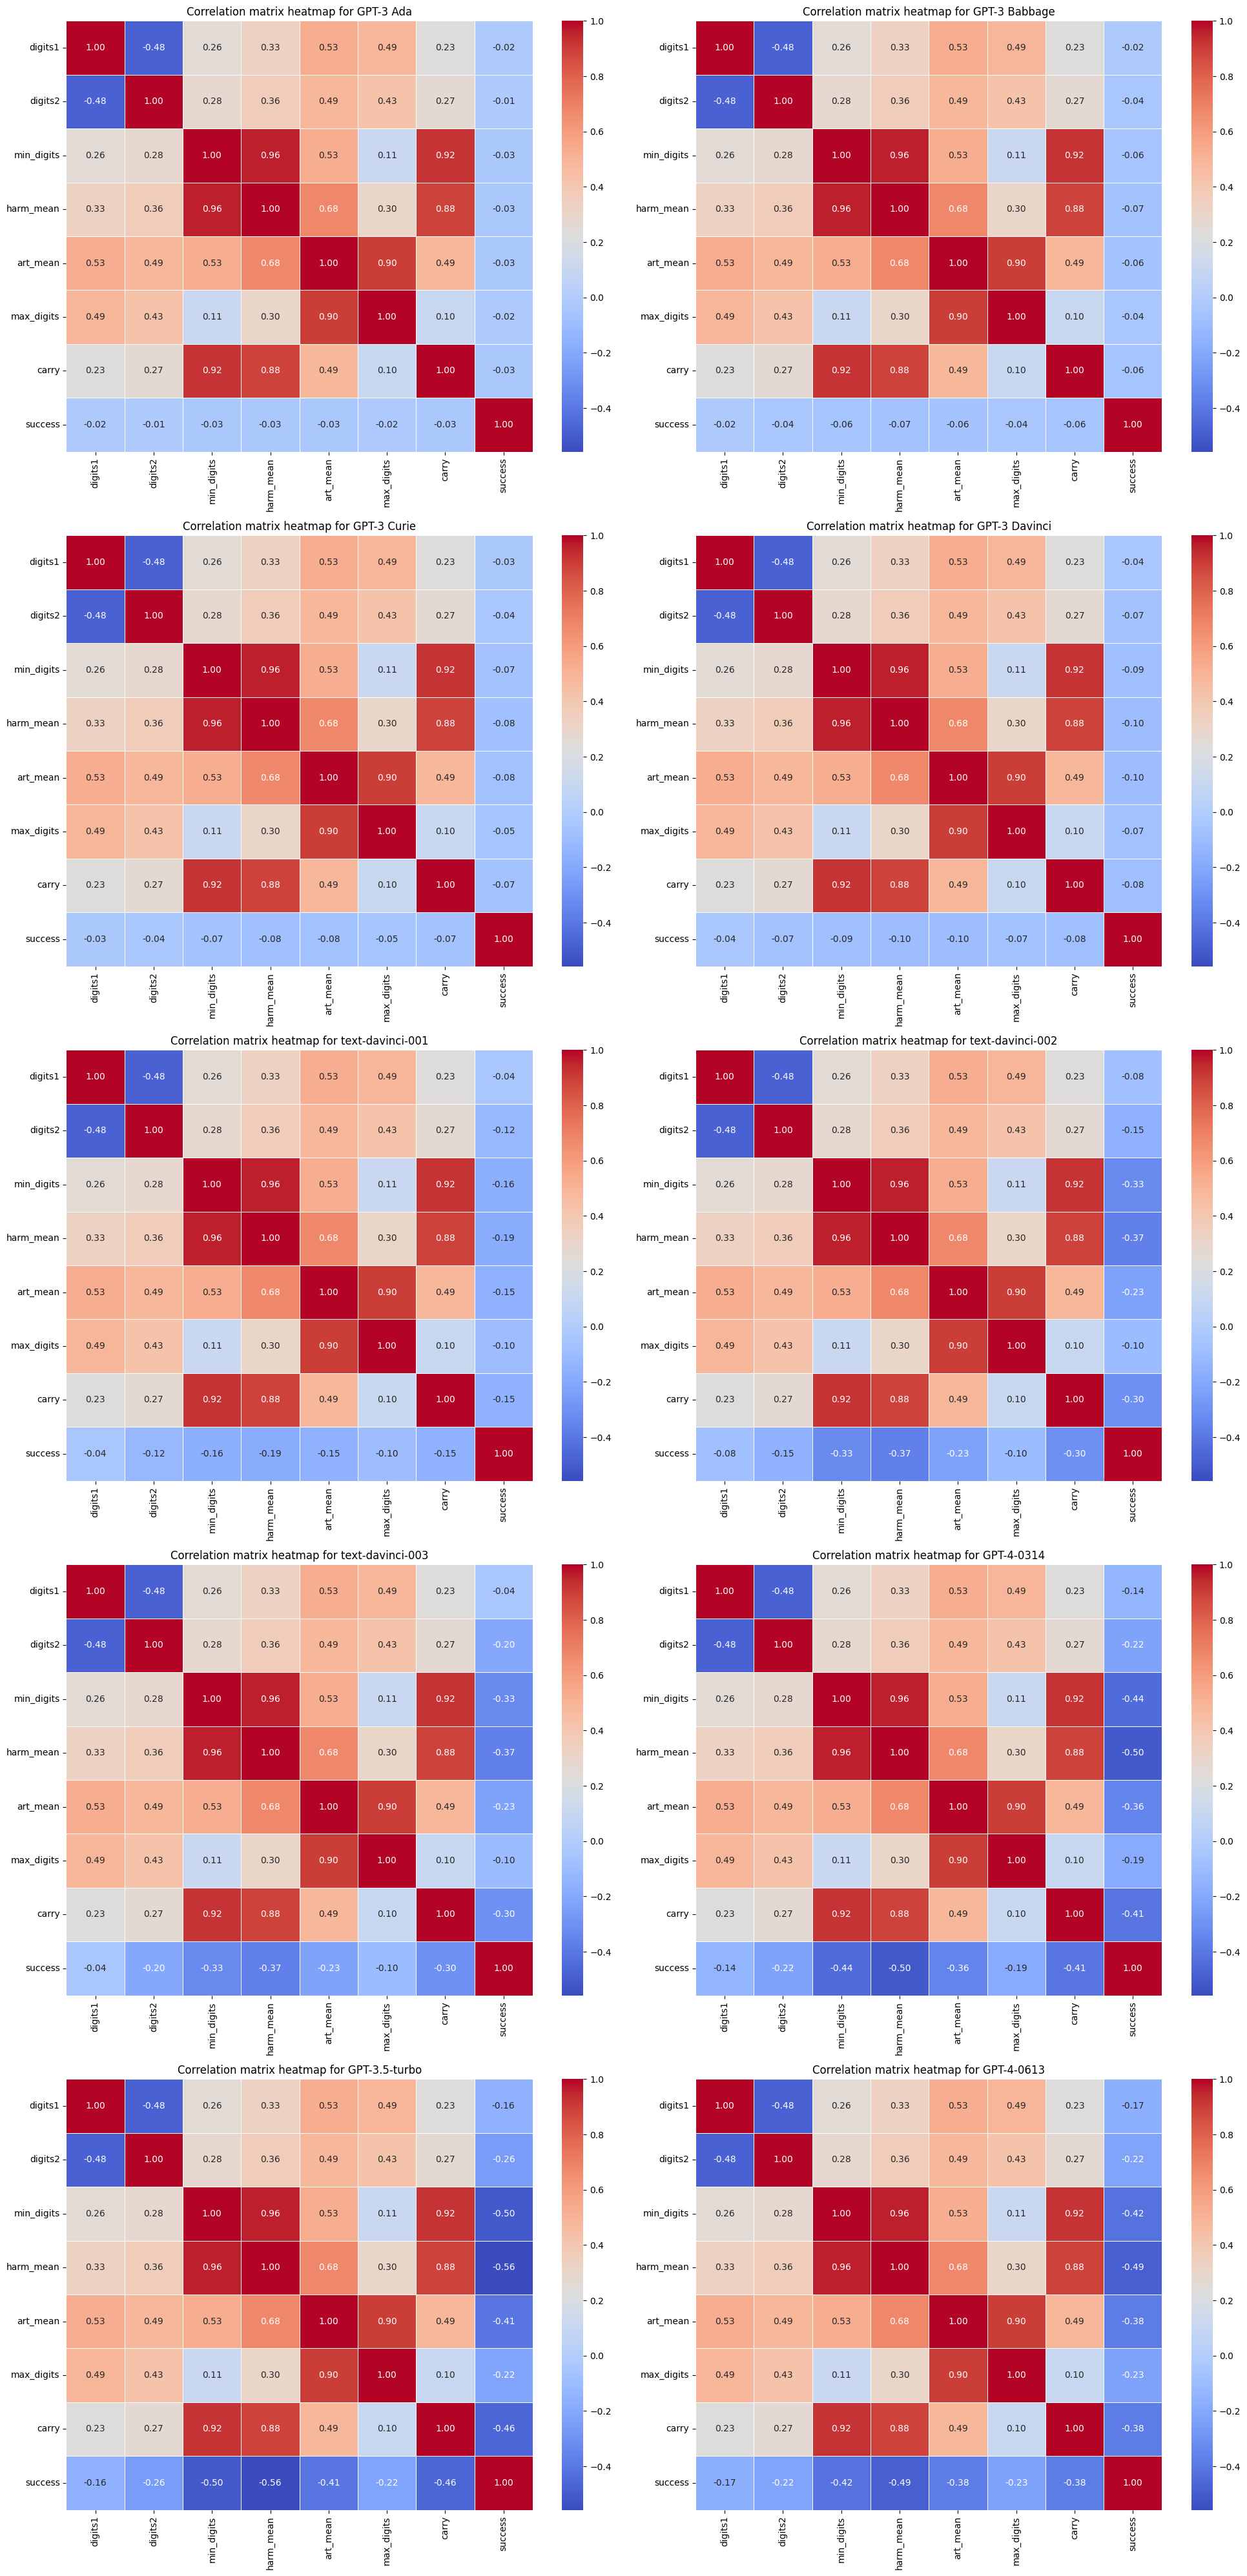

In [15]:
n_llms = len(llms)
ncols = 2
nrows = n_llms // ncols + (n_llms % ncols > 0)

global_min = min(all_corrs[llm].min().min() for llm in llms)
global_max = max(all_corrs[llm].max().max() for llm in llms)

plt.figure(figsize=(ncols * 10, nrows * 8))

# Loop through each LLM
for index, llm in enumerate(llms):
    plt.subplot(nrows, ncols, index + 1)

    # Create the heatmap
    sns.heatmap(all_corrs[llm], annot=True, fmt=".2f", cmap="coolwarm", vmin=global_min, vmax=global_max,linewidths=0.5)
    plt.title(f"Correlation matrix heatmap for {llm}")
    #heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

We find little correlation between the features and success from GPT-3 Ada, GPT-3 Babbage, GPT-3 Curie, and GPT-3 Davinci. However, we observe moderate to strong correlations between the features (especially harm_mean and carry) and success for all other LLMs.

Below we plot histograms of successes and failures for each meta-feature and for each LLM. These plots will provide us with information on the discriminative power of each feature with respect to success in the task.

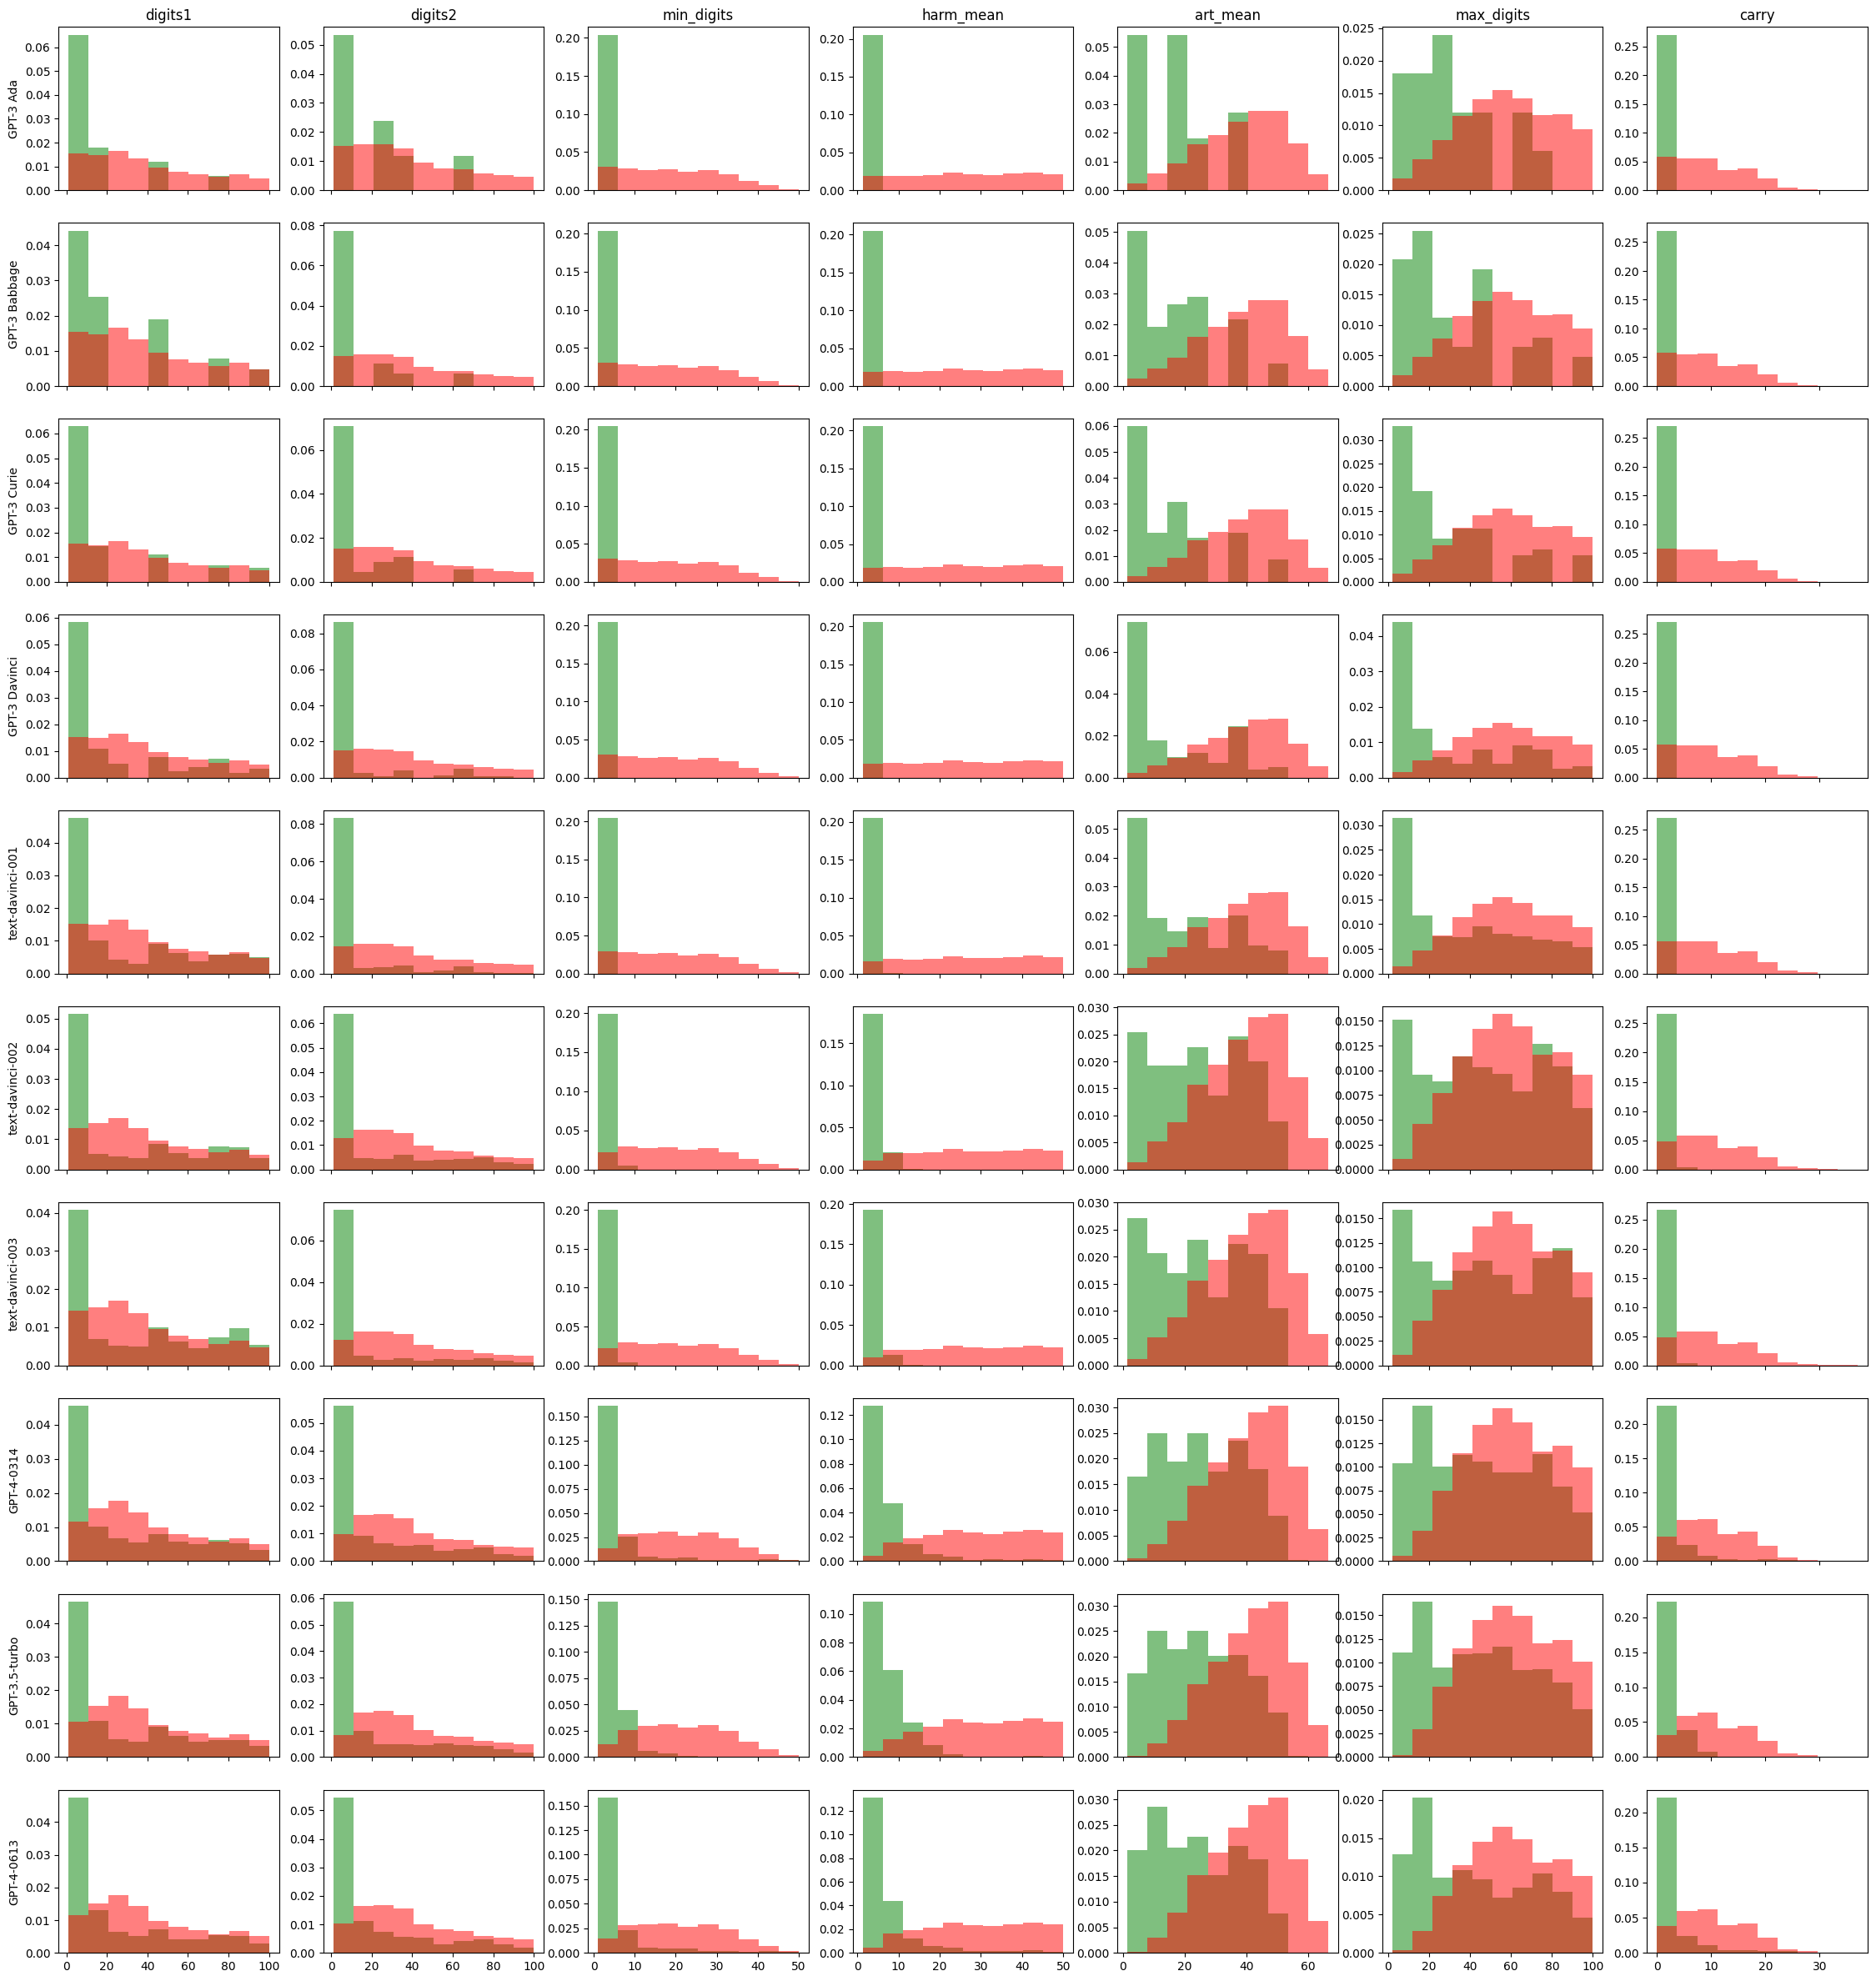

In [16]:
feats = ['digits1', 'digits2', 'min_digits', 'harm_mean', 'art_mean', 'max_digits', 'carry']

fig, axes = plt.subplots(len(llms), len(feats), figsize=(4 * len(feats), 3 * len(llms)), sharex="col")

for i, llm in enumerate(llms):
    merged_df_success = addition_data[(addition_data['success'] == 1) & (addition_data['llm'] == llm)]
    merged_df_fail = addition_data[(addition_data['success'] == 0) & (addition_data['llm'] == llm)]
    for j, feat in enumerate(feats):
        bins = np.histogram(np.hstack((merged_df_success[feat], merged_df_fail[feat])), bins=10)[1]
        axes[i, j].hist(merged_df_success[feat], density=True, alpha=0.5, facecolor='green', label="Success", bins=bins)
        axes[i, j].hist(merged_df_fail[feat], density=True, alpha=0.5, facecolor='red', label="Fail", bins=bins)
        axes[0, j].set_title(feat)
    axes[i, 0].set_ylabel(llm)
plt.show()

Given the above, harm_mean (i.e., the harmonic mean of the number of digits in the two numbers) and carry (the number of carry operations needed to add the two numbers) may be good choices for predicting success in the task.

## Assessors

Here we construct assessors and some standard baselines to later compare the predictive performance of the measurement layout.

In [17]:
# Function to split data into train and test
def split_data(df, test_size=0.2):
    return train_test_split(df, test_size=test_size, random_state=42)

In [18]:
# Dictionaries to hold the training and test data
train_dict = {}
test_dict = {}

# Split data for each LLM
for llm in llms:
    # Filter data for the current LLM
    llm_data = addition_data[addition_data['llm'] == llm]

    # Split the data into training and test sets
    train, test = train_test_split(llm_data, test_size=0.2)  # Adjust test_size as needed

    # Store the split data in the dictionaries
    train_dict[llm] = train
    test_dict[llm] = test


Print the size of the training and test sets.

Note: As the dataset is imbalanced, it's important to print the value counts for the test set to ensure there are at least a few instances for each label, i.e., success (1) and failure (0). If any of the labels has no instances, we won't be able to calculate some metrics, such as AUROC.

In [19]:
for llm in llms:
    train_size = len(train_dict[llm])
    test_size = len(test_dict[llm])

    success_counts = test_dict[llm]['success'].value_counts().to_string()

    print(f"{llm}:")
    print(f"  Train size: {train_size}")
    print(f"  Test size: {test_size}")
    print(f"  Test set success counts:\n{success_counts}\n")

GPT-3 Ada:
  Train size: 37704
  Test size: 9426
  Test set success counts:
0    9422
1       4

GPT-3 Babbage:
  Train size: 37704
  Test size: 9426
  Test set success counts:
0    9410
1      16

GPT-3 Curie:
  Train size: 37704
  Test size: 9426
  Test set success counts:
0    9404
1      22

GPT-3 Davinci:
  Train size: 37704
  Test size: 9426
  Test set success counts:
0    9396
1      30

text-davinci-001:
  Train size: 37704
  Test size: 9426
  Test set success counts:
0    9320
1     106

text-davinci-002:
  Train size: 37704
  Test size: 9426
  Test set success counts:
0    8967
1     459

text-davinci-003:
  Train size: 37704
  Test size: 9426
  Test set success counts:
0    8974
1     452

GPT-4-0314:
  Train size: 37704
  Test size: 9426
  Test set success counts:
0    8325
1    1101

GPT-3.5-turbo:
  Train size: 37704
  Test size: 9426
  Test set success counts:
0    8120
1    1306

GPT-4-0613:
  Train size: 37704
  Test size: 9426
  Test set success counts:
0    8364
1   

Here we construct a boosting tree model using all the features, plot the importance of each feature, and subsequently select those with the highest importance.

Accuracy for LLM GPT-3 Ada: 1.00


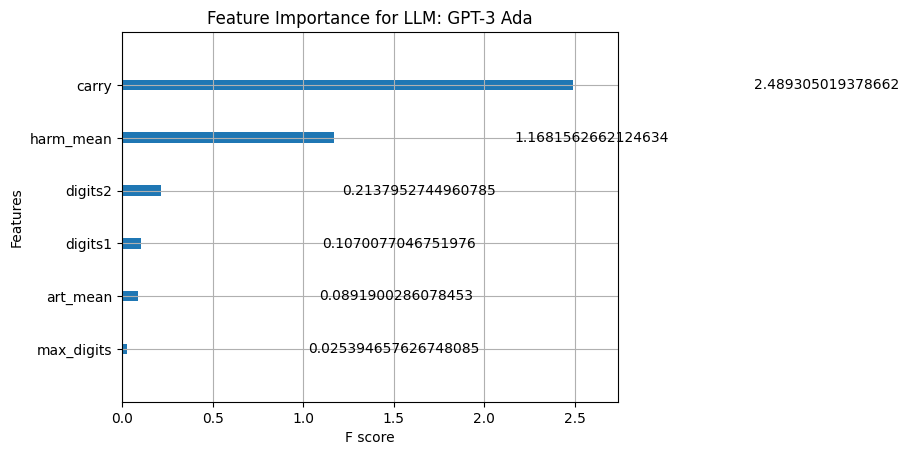

Accuracy for LLM GPT-3 Babbage: 1.00


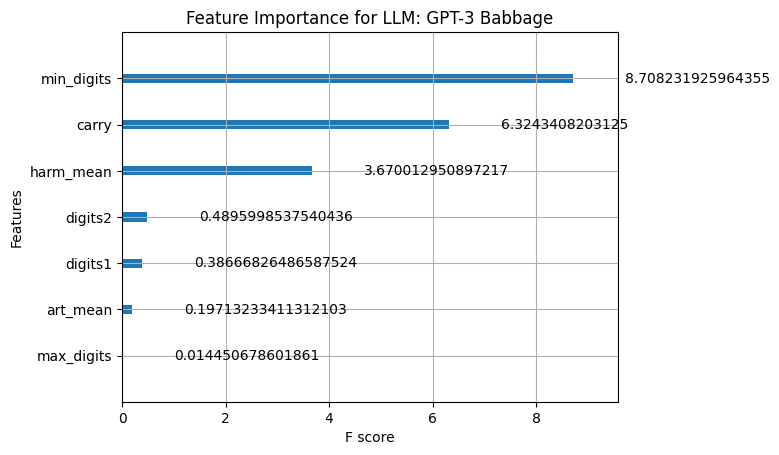

Accuracy for LLM GPT-3 Curie: 1.00


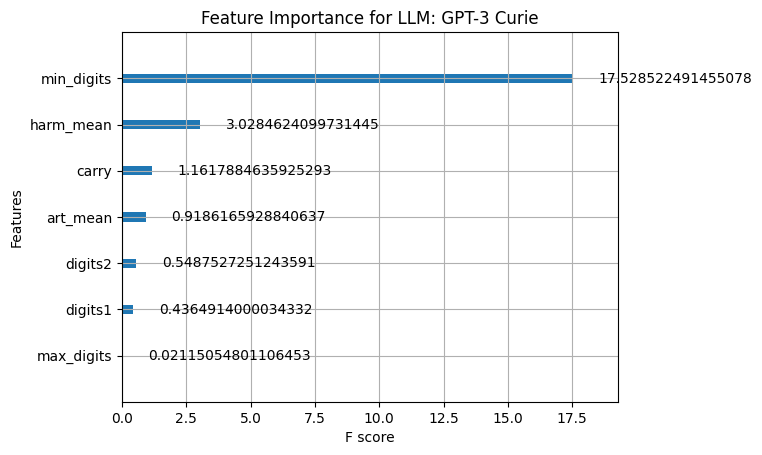

Accuracy for LLM GPT-3 Davinci: 1.00


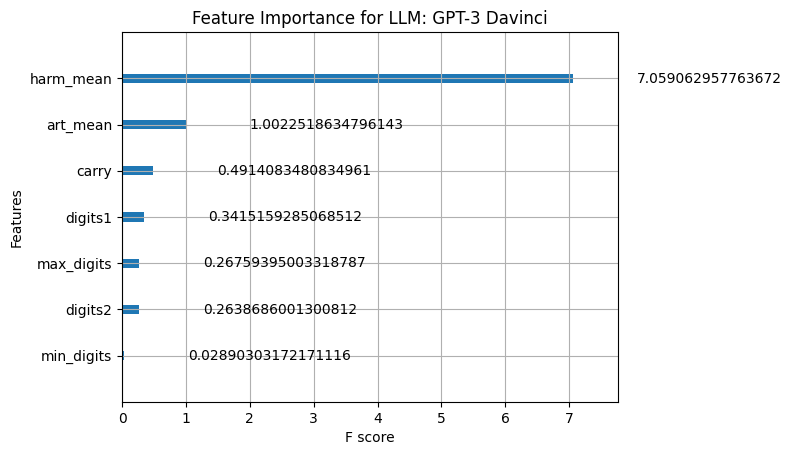

Accuracy for LLM text-davinci-001: 0.99


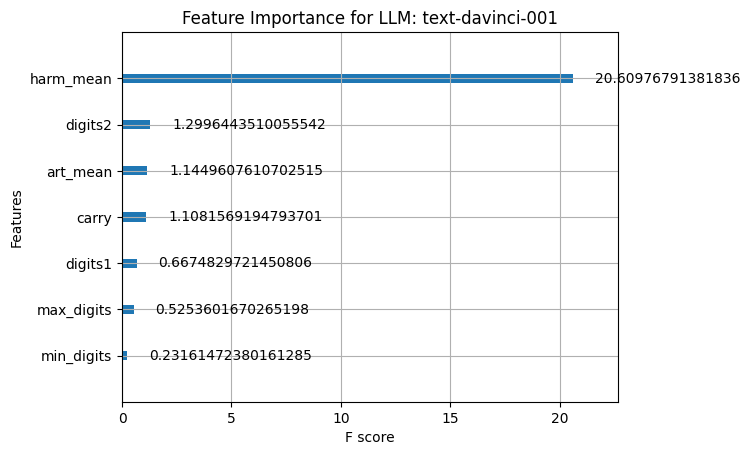

Accuracy for LLM text-davinci-002: 0.97


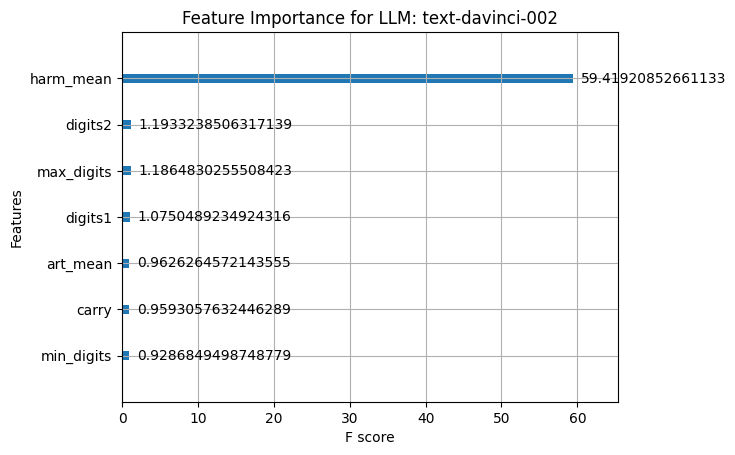

Accuracy for LLM text-davinci-003: 0.98


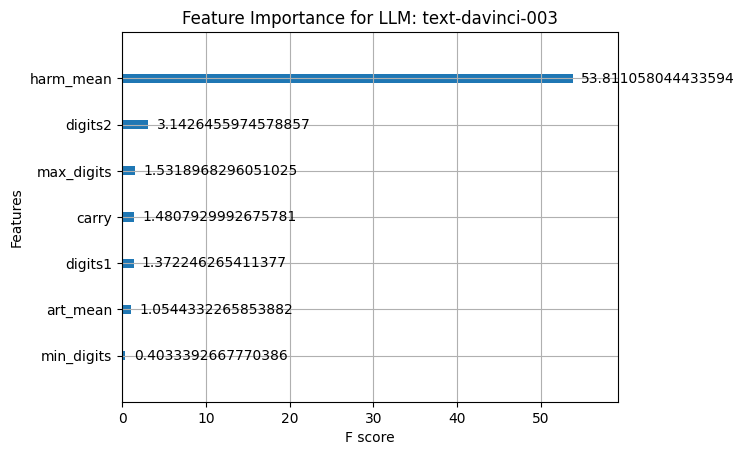

Accuracy for LLM GPT-4-0314: 0.96


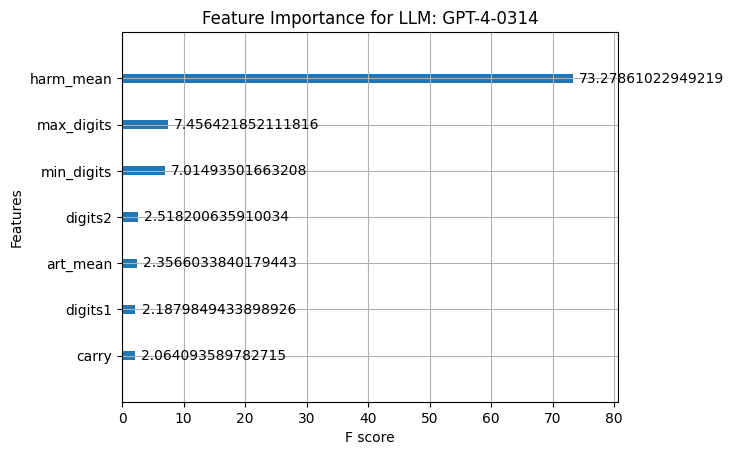

Accuracy for LLM GPT-3.5-turbo: 0.95


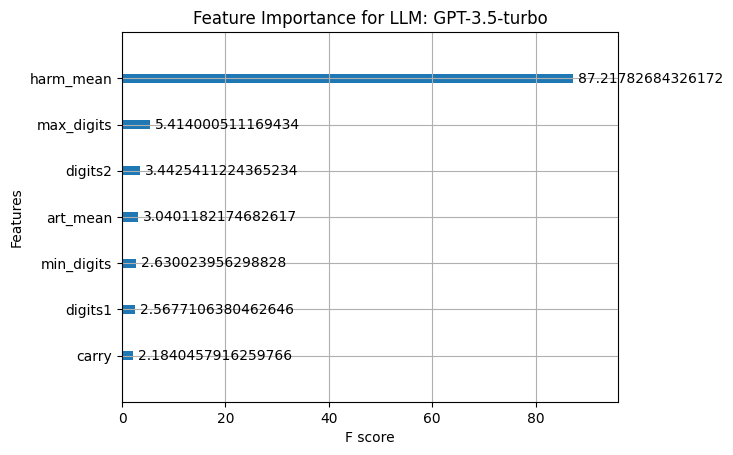

Accuracy for LLM GPT-4-0613: 0.96


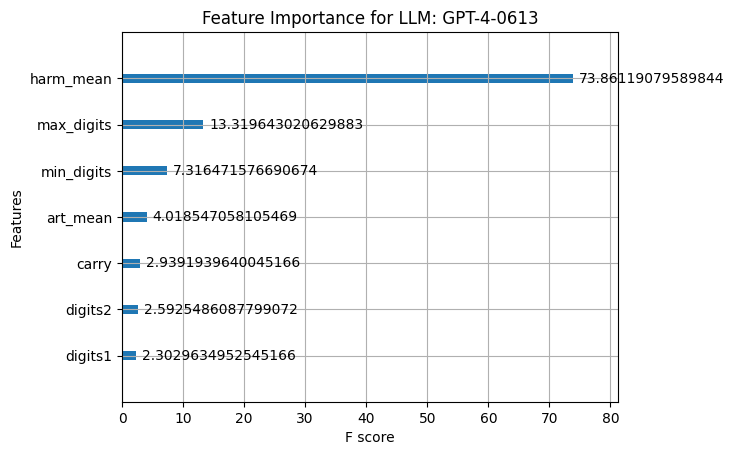

In [20]:
features = ['digits1', 'digits2', 'min_digits', 'harm_mean', 'art_mean', 'max_digits', 'carry']

for llm in train_dict:
    # Extract training and testing data for the current LLM
    X_train = train_dict[llm][features]
    y_train = train_dict[llm]['success']
    X_test = test_dict[llm][features]
    y_test = test_dict[llm]['success']

    # Initialize and train the XGBoost classifier
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)

    # Evaluate the model on the test set
    accuracy = model.score(X_test, y_test)
    print(f'Accuracy for LLM {llm}: {accuracy:.2f}')

    # Plot feature importance
    xgb.plot_importance(model, importance_type='gain')
    plt.title(f'Feature Importance for LLM: {llm}')
    plt.show()

It seems that harm_mean and carry together are the most important features across the LLMs, so we will use these to build the assessors and later the measurement layouts. harm_mean and carry also demonstrated decent correlations with success and good discriminatory power, as seen from the plots above.

Here we train two assessors: a logistic regression and an XGBoost model and add some baselines.

In [21]:
list_features = ['harm_mean','carry']

predictive_methods_df = pd.DataFrame()
for predictive_method in [LogisticRegression, XGBClassifier]:
    for llm in llms:
        print(llm)
        df_train = train_dict[llm]  # default training set
        df_test = test_dict[llm]  # default test set
        # in distribution performance
        BrierScore, Calibration, Refinement, roc_auc, accuracy, trained_method = evaluate_predictive_method(df_train, df_test,
                                                                                                  list_features,
                                                                                                  "success",
                                                                                                  predictive_method=predictive_method,
                                                                                                  return_trained_method=True,
                                                                                                  compute_accuracy=True)
        predictive_methods_df = pd.concat([predictive_methods_df, pd.DataFrame(
            {"predictive_method": predictive_method.__name__, "llm": llm, "BrierScore": BrierScore,
             "Calibration": Calibration, "Refinement": Refinement, "AUROC": roc_auc, "trained_method": trained_method, "Accuracy":accuracy},
            index=[0])])

        for baseline in ["always_1", "always_0", "average_success_on_train"]:
            if baseline == "always_1": #this baseline predicts success (1) with probability 1 for each instance
                predictions = np.ones(len(df_test))
            elif baseline == "always_0": #this baseline predicts success (1) with probability 0 for each instance
                predictions = np.zeros(len(df_test))
            elif baseline == "average_success_on_train": #this baseline predicts success (1) with the average probability of success on the training sets for each instance
                predictions = np.ones(len(df_test)) * df_train["success"].mean()
            else:
                raise ValueError("baseline not recognized")

            BrierScore, Calibration, Refinement = brierDecomp(predictions, df_test["success"])
            roc_auc = roc_auc_score(df_test["success"], predictions)
            predictive_methods_df = pd.concat([predictive_methods_df, pd.DataFrame(
                {"predictive_method": baseline, "llm": llm, "BrierScore": BrierScore, "Calibration": Calibration,
                  "Refinement": Refinement, "AUROC": roc_auc,  "Accuracy": accuracy , }, index=[0])])

GPT-3 Ada
GPT-3 Babbage
GPT-3 Curie
GPT-3 Davinci
text-davinci-001
text-davinci-002
text-davinci-003
GPT-4-0314
GPT-3.5-turbo
GPT-4-0613
GPT-3 Ada
GPT-3 Babbage
GPT-3 Curie
GPT-3 Davinci
text-davinci-001
text-davinci-002
text-davinci-003
GPT-4-0314
GPT-3.5-turbo
GPT-4-0613


In [22]:
predictive_methods_df[['predictive_method', 'llm', 'AUROC', 'BrierScore', 'Calibration', 'Refinement','Accuracy']].sort_values(by="BrierScore")

,predictive_method,llm,AUROC,BrierScore,Calibration,Refinement,Accuracy
0,XGBClassifier,GPT-3 Ada,0.996896,0.000396,5.166367e-09,0.000424,0.999576
0,LogisticRegression,GPT-3 Ada,0.994653,0.000414,4.833987e-09,0.000424,0.999576
0,average_success_on_train,GPT-3 Ada,0.500000,0.000424,6.330932e-09,0.000424,0.999576
0,average_success_on_train,GPT-3 Ada,0.500000,0.000424,6.330932e-09,0.000424,0.999576
0,always_0,GPT-3 Ada,0.500000,0.000424,1.800798e-07,0.000424,0.999576
...,...,...,...,...,...,...,...
0,always_1,GPT-3 Curie,0.500000,0.997666,0.000000e+00,0.000000,0.997666
0,always_1,GPT-3 Babbage,0.500000,0.998303,0.000000e+00,0.000000,0.998303
0,always_1,GPT-3 Babbage,0.500000,0.998303,0.000000e+00,0.000000,0.998303
0,always_1,GPT-3 Ada,0.500000,0.999576,0.000000e+00,0.000000,0.999576


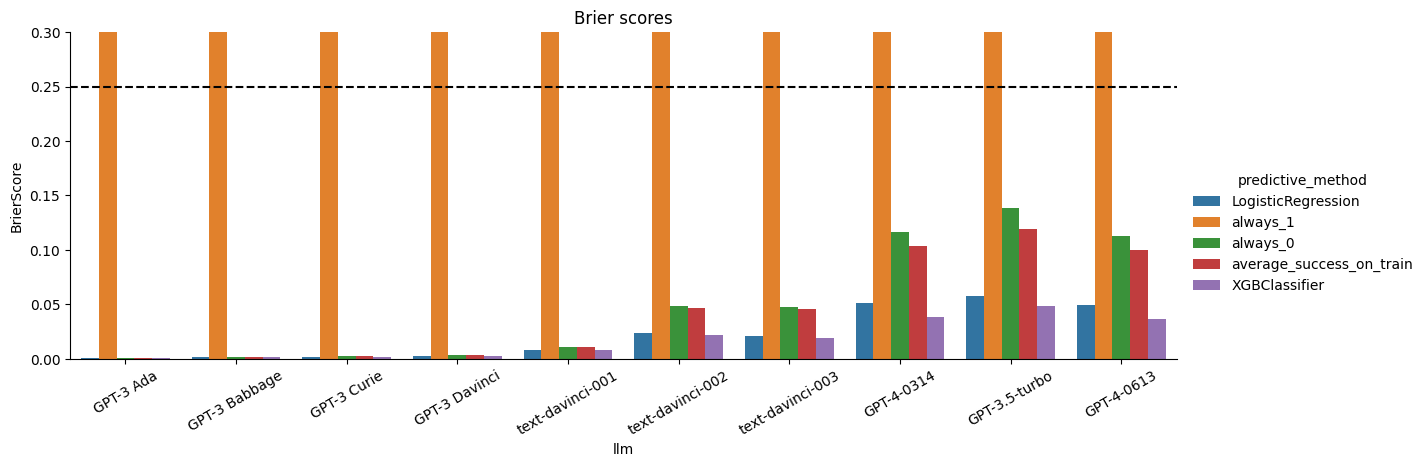

In [23]:
sns.catplot(x="llm", y="BrierScore", hue="predictive_method", data=predictive_methods_df, kind="bar", height=4, aspect=3)
plt.ylim(0, .3)
plt.axhline(y=0.25, color='black', linestyle='--')
plt.title("Brier scores")
plt.xticks(rotation=30)
plt.show()

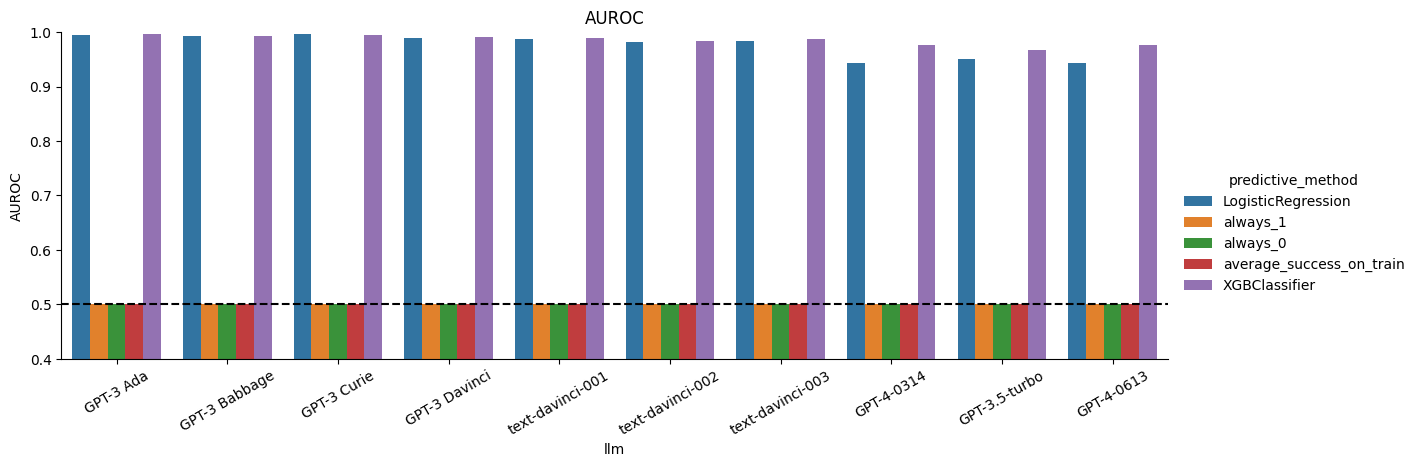

In [24]:
sns.catplot(x="llm", y="AUROC", hue="predictive_method", data=predictive_methods_df, kind="bar", height=4, aspect=3)
plt.ylim(0.4, 1)
plt.axhline(y=0.5, color='black', linestyle='--')
plt.title("AUROC")
plt.xticks(rotation=30)
plt.show()

## Measurment layout

In [25]:
def predict(m, trace, relevantData):
  with m:

    predictions = pm.sample_posterior_predictive(trace, var_names=["taskPerformance"], return_inferencedata=False,predictions=True,extend_inferencedata=False)
    predictionChainRuns = predictions["taskPerformance"][:,:,0:len(relevantData)]
    predictionsInstance = np.mean(predictionChainRuns, (0,1))

    return predictionsInstance

In [26]:
def setupSumModel(data, noise=False, slopes=False):

  # define bounds
  abilityMin = {}
  abilityMax = {}

  minSizeAbility = (data['harm_mean'].min())
  maxSizeAbility = (data['harm_mean'].max())

  minMemoryAbility = (data['carry'].min())
  maxMemoryAbility = (data['carry'].max())

  abilityMin["sizeAbility"] = minSizeAbility
  abilityMax["sizeAbility"] = maxSizeAbility

  abilityMin["memoryAbility"] = minMemoryAbility
  abilityMax["memoryAbility"] = maxMemoryAbility


  m = pm.Model()
  with m:

    # Define abilities and their priors

    sizeAbility = pm.Uniform("sizeAbility", minSizeAbility, maxSizeAbility)
    memoryAbility = pm.Uniform("memoryAbility", minMemoryAbility, maxMemoryAbility)

    #logistic_slope_size = pm.HalfNormal('logistic_slope_size',sigma=1)
    #logistic_slope_memory = pm.HalfNormal('logistic_slope_memory',sigma=1)

    #exponent = pm.Normal('exponent',mu=0, sigma=1)

    # Define environment variables as MutableData

    digitsMean = pm.MutableData("digitsMean", data['harm_mean'].values)
    numCarry = pm.MutableData("numCarry", data['carry'].values)

    if noise:
        noise_level = pm.Uniform("noise_level", 0, 1)
        average_success = data["success"].mean()  # this is using data twice

    if slopes:
        # add slopes parameters for all of the three capabilities. We want a distribution with positive support only and peaked at 1:
        # use a gamma distribution:
        alpha = beta = 15  # these lead to a mean of 1 and standard deviation of 0.26 for the prior
        size_slope = pm.Gamma("size_slope", alpha, beta)
        memory_slope = pm.Gamma("memory_slope", alpha, beta)

    # Margins

    sizePerformance = pm.Deterministic("sizePerformance", logistic(margin(sizeAbility,digitsMean), k=size_slope if slopes else 1)) #logistic_slope_size
    memoryPerformance = pm.Deterministic("memoryPerformance", logistic(margin(memoryAbility,numCarry), k=memory_slope if slopes else 1)) #logistic_slope_memory

    perfList = [sizePerformance,memoryPerformance]
    integratedPerformance =  np.prod(perfList)

    if noise :
        finalPerformance = pm.Deterministic("finalPerformance", (1 - noise_level) * integratedPerformance + noise_level * average_success)
    else:
        finalPerformance = integratedPerformance



    taskPerformance = pm.Bernoulli("taskPerformance", finalPerformance, observed = data['success'])

  return m

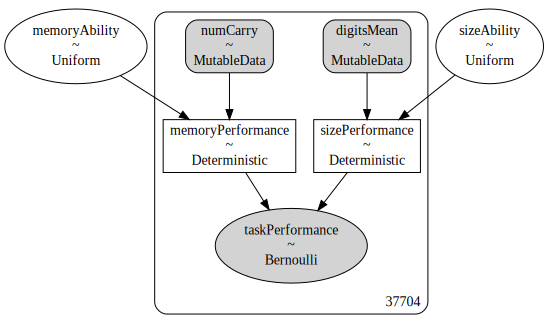

In [29]:
LLM = 'GPT-3.5-turbo'

model = setupSumModel(train_dict[LLM], noise = False, slopes = False)
pm.model_to_graphviz(model)

In [30]:
model_gpt3_5 = setupSumModel(train_dict[LLM], noise = False, slopes = False)

with model_gpt3_5:
  trace_gpt3_5 = pm.sample(1000, target_accept=0.95, chains=2)

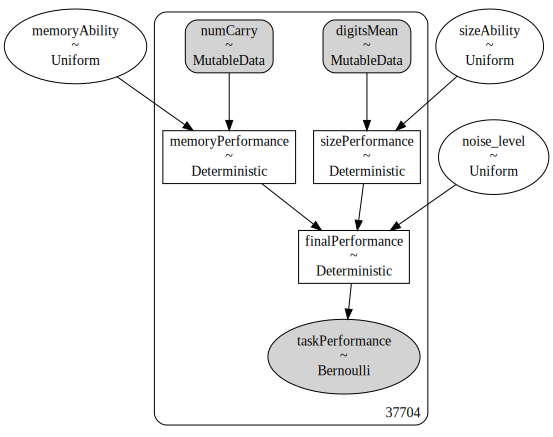

In [42]:
LLM = 'GPT-3.5-turbo'

model = setupSumModel(train_dict[LLM], noise = True, slopes = False)
pm.model_to_graphviz(model)

In [ ]:
model_gpt3_5_noise = setupSumModel(train_dict[LLM], noise = True, slopes = False)

with model_gpt3_5_noise:
  trace_gpt3_5_noise = pm.sample(1000, target_accept=0.95, chains=2)

In [ ]:
LLM = 'GPT-3.5-turbo'

model = setupSumModel(train_dict[LLM], noise = False, slopes = True)
pm.model_to_graphviz(model)

In [ ]:
model_gpt3_5_slopes = setupSumModel(train_dict[LLM], noise = False, slopes = True)

with model_gpt3_5_slopes:
  trace_gpt3_5_slopes = pm.sample(2000, target_accept=0.95, chains=2)

In [ ]:
LLM = 'GPT-3.5-turbo'

model = setupSumModel(train_dict[LLM], noise = True, slopes = True)
pm.model_to_graphviz(model)

In [ ]:
model_gpt3_5_noise_slopes = setupSumModel(train_dict[LLM], noise = True, slopes = True)

with model_gpt3_5_noise_slopes:
  trace_gpt3_5_noise_slopes = pm.sample(2000, target_accept=0.95, chains=2)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'sizeAbility'}>,
        <Axes: title={'center': 'sizeAbility'}>],
       [<Axes: title={'center': 'memoryAbility'}>,
        <Axes: title={'center': 'memoryAbility'}>]], dtype=object)

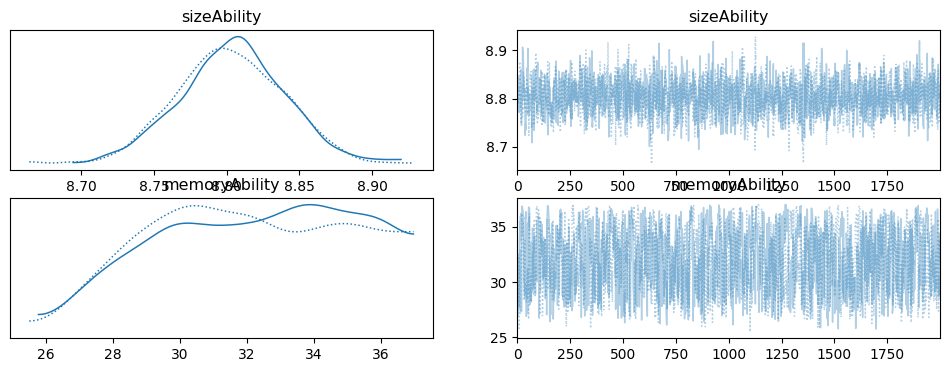

In [31]:
noise = True
slopes = False

if not noise and not slopes:
  abilities = ['sizeAbility','memoryAbility'] #'logistic_slope_size','logistic_slope_memory'
elif noise and not slopes:
  abilities = ['sizeAbility','memoryAbility','noise']
elif not noise and slopes:
  abilities = ['sizeAbility','memoryAbility','size_slope','memory_slope']
else:
  abilities = ['sizeAbility','memoryAbility','size_slope','memory_slope','noise'] #'logistic_slope_memory','memoryAbility','logistic_slope_size'

az.plot_trace(data=trace_gpt3_5_noise['posterior'][abilities])

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


<Axes: >

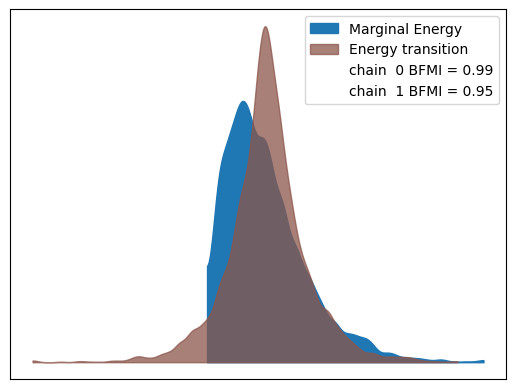

In [32]:
az.plot_energy(
    data = trace_gpt3_5_noise
)

array([<Axes: title={'center': 'sizeAbility'}>,
       <Axes: title={'center': 'memoryAbility'}>], dtype=object)

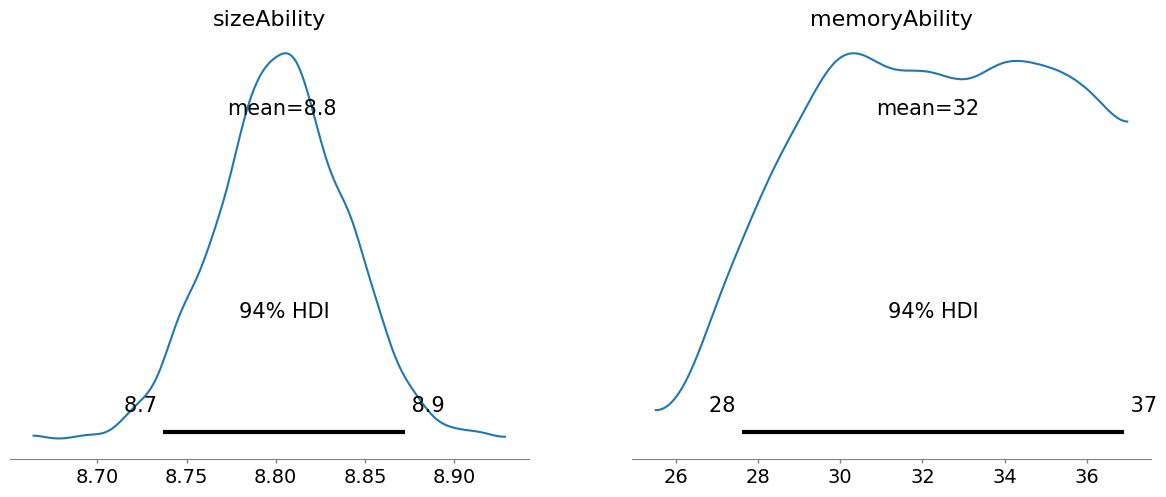

In [33]:
az.plot_posterior(data = trace_gpt3_5_noise['posterior'][abilities])

In [34]:
az.summary(trace_gpt3_5_noise['posterior'][abilities])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sizeAbility,8.803,0.037,8.737,8.873,0.001,0.001,1640.0,1597.0,1.0
memoryAbility,32.126,2.811,27.608,36.899,0.095,0.069,816.0,860.0,1.0


In [35]:
az.summary(trace_gpt3_5['posterior'][abilities[1]])['hdi_97%'][0]

36.899

In [36]:
def brierScore(preds, outs):
  return 1/len(preds) * sum( (preds-outs)**2 )

In [37]:
def predict(m, trace, df_test):
    with m:
        predictions = pm.sample_posterior_predictive(trace, var_names=["taskPerformance"], return_inferencedata=False,
                                                     predictions=True, extend_inferencedata=False, random_seed=0)
        # the above generates one predictive sample for each posterior sample
        predictionChainRuns = predictions["taskPerformance"][:, :, 0:len(df_test)]
        predictionsInstance = np.mean(predictionChainRuns, (0, 1))

        return predictionsInstance

In [38]:
df_train = train_dict[LLM]
df_test = test_dict[LLM]

model_initialize = setupSumModel(df_test,noise = noise, slopes = slopes)

predictions = predict(model_initialize, trace_gpt3_5_noise, df_test)

modelBrierScore, modelCalibration, modelRefinement = brierDecomp(predictions, df_test["success"])
roc_auc = roc_auc_score(df_test["success"], predictions)

average_score = brierScore(np.mean(df_train["success"]) * np.ones_like(df_test["success"]), df_test["success"])

print("Predictions with: " + LLM + ", with No. of Examples: " + str(len(df_train["success"]))+". modelBrierScore: "+str(modelBrierScore)+" versus averages: "+str(average_score))
print('AUROC:',roc_auc)

Predictions with: GPT-3.5-turbo, with No. of Examples: 37704. modelBrierScore: 0.06898674468226208 versus averages: 0.11935620194313458
AUROC: 0.9403217152362346


<Axes: ylabel='Count'>

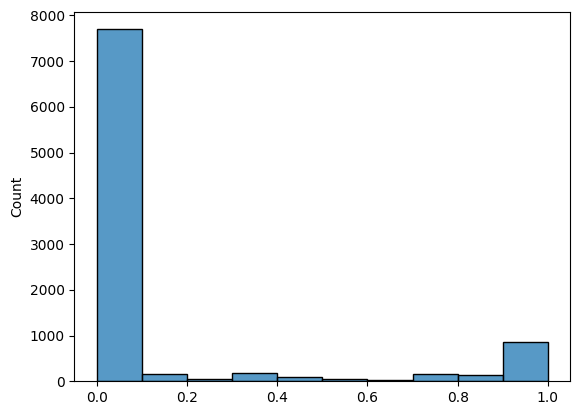

In [39]:
sns.histplot(predictions, bins=10, kde=False)

In [40]:
from sklearn.calibration import calibration_curve

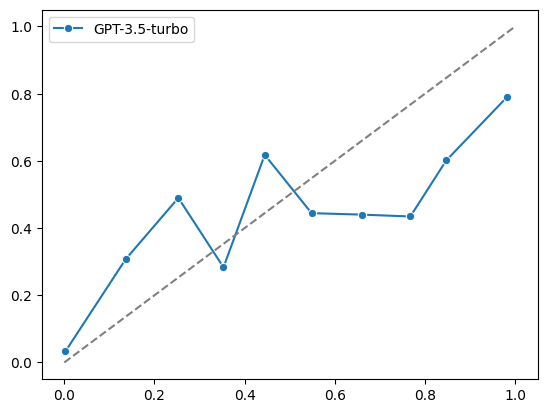

In [41]:
n_bins = 10

prob_true, prob_pred = calibration_curve(test_dict[LLM]['success'], predictions, n_bins=n_bins, strategy='uniform')

        # Plot the calibration curve
sns.lineplot(x=prob_pred, y=prob_true, marker='o', label=LLM)

    # Add the diagonal line for perfect calibration
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

In [ ]:
scores_dict = {}
means_dict = {}
probabilities = {}
list_features = ['diff2','carry'] #'carry'
compute_accuracy = True

for llm in llms:
    print(llm)
    #relevantData = train_dict[llm][list_features]
    #taskResults = train_dict[llm]['success']

    m_llm, abilityMin, abilityMax = setupSumModel(train_dict, llm)

    with m_llm:
      llm_trace = pm.sample(2000, target_accept=0.95, chains = 2)

    relevantDataTest = test_dict[llm][list_features]
    taskResultsTest = test_dict[llm]['success']

    m_llm, abMin, abMax = setupSumModel(test_dict, llm, includeNoise = False, simpleGraph = False)

    predictions = predict(m_llm, llm_trace, relevantDataTest) #, len(relevantData))

    probabilities[llm] = predictions

    modelBrierScore, modelCalibration, modelRefinement = brierDecomp(predictions, taskResultsTest)
    roc_auc = roc_auc_score(taskResultsTest, predictions)

    if compute_accuracy:
        # compute accuracy by thresholding at 0.5
        y_pred_binary = predictions > 0.5
        accuracy = np.mean(y_pred_binary == taskResultsTest)


    scores_dict[llm] = {'BrierScore': modelBrierScore, 'Calibration':modelCalibration,'Refinement':modelRefinement,'AUROC':roc_auc,'Accuracy':accuracy}
    # Store the means of the abilities for each llm
    means_dict[llm] = {ability: float(np.mean(llm_trace.posterior[ability])) for ability in ['sizeAbility','memoryAbility']} #'memoryAbility'
    predictive_methods_df = pd.concat([predictive_methods_df, pd.DataFrame({"predictive_method": 'Measurement layout', "llm": llm, "BrierScore": modelBrierScore, "Calibration": modelCalibration, "Refinement": modelRefinement, "AUROC": roc_auc,'Accuracy':accuracy}, index=[0])])


GPT-3 Ada


GPT-3 Babbage


GPT-3 Curie


GPT-3 Davinci


text-davinci-001


text-davinci-002


text-davinci-003


GPT-4 v1


GPT-3.5-turbo


GPT-4 v2


In [ ]:
means_dict

{'GPT-3 Ada': {'sizeAbility': 1.3638406412656914,
  'memoryAbility': 0.024997283182985428},
 'GPT-3 Babbage': {'sizeAbility': 1.3667448153861905,
  'memoryAbility': 0.027560206776077782},
 'GPT-3 Curie': {'sizeAbility': 1.3710394659523448,
  'memoryAbility': 0.0315608431733448},
 'GPT-3 Davinci': {'sizeAbility': 1.3839789939575975,
  'memoryAbility': 0.044922489739913155},
 'text-davinci-001': {'sizeAbility': 1.7906749196900398,
  'memoryAbility': 0.5681304238855209},
 'text-davinci-002': {'sizeAbility': 4.718277617328255,
  'memoryAbility': 3.9794368319031035},
 'text-davinci-003': {'sizeAbility': 4.880864576059777,
  'memoryAbility': 4.0826130457277054},
 'GPT-4 v1': {'sizeAbility': 9.457598201034449,
  'memoryAbility': 19.653705682356893},
 'GPT-3.5-turbo': {'sizeAbility': 11.213882076920243,
  'memoryAbility': 18.702402869366523},
 'GPT-4 v2': {'sizeAbility': 10.531777058096774,
  'memoryAbility': 19.786776262047788}}

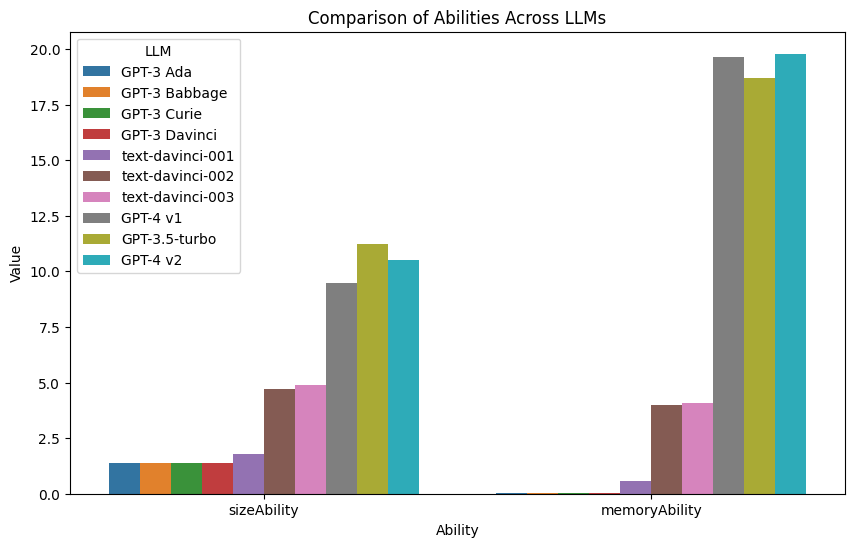

In [ ]:
# Convert the nested dictionary to a DataFrame
mean_abilities = pd.DataFrame(means_dict).reset_index().melt(id_vars='index', var_name='LLM', value_name='Value')
mean_abilities.rename(columns={'index': 'Ability'}, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Ability', y='Value', hue='LLM', data=mean_abilities)
plt.title('Comparison of Abilities Across LLMs')
plt.show()

In [ ]:
scores_mes_lay = pd.DataFrame.from_dict(scores_dict, orient='index').reset_index()
scores_mes_lay.rename(columns={'index': 'llm'}, inplace=True)
scores_mes_lay.sort_values('BrierScore')

,llm,BrierScore,Calibration,Refinement,AUROC,Accuracy
0,GPT-3 Ada,0.004640,0.003281,0.000803,0.975709,0.999191
1,GPT-3 Babbage,0.008605,0.001650,0.006851,0.979082,0.992718
3,GPT-3 Davinci,0.009887,0.001791,0.007795,0.980324,0.990291
2,GPT-3 Curie,0.010126,0.002556,0.007127,0.985566,0.991100
4,text-davinci-001,0.029205,0.005080,0.024069,0.977024,0.959547
6,text-davinci-003,0.060060,0.012193,0.047682,0.963156,0.885922
5,text-davinci-002,0.066620,0.013547,0.053686,0.958494,0.870550
8,GPT-3.5-turbo,0.117730,0.008725,0.108789,0.913336,0.845469
7,GPT-4 v1,0.133256,0.010051,0.123500,0.870194,0.813916
9,GPT-4 v2,0.153367,0.010794,0.141487,0.823928,0.788835


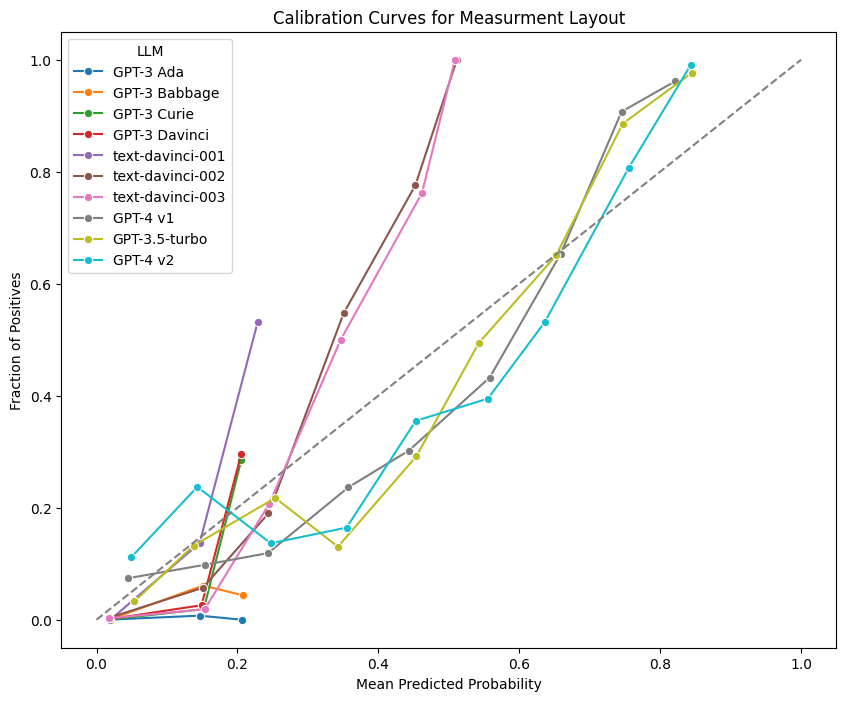

In [ ]:
n_bins = 10

plt.figure(figsize=(10, 8))  # Create a new figure for each predictive method

for llm in probabilities.keys():
    # Calculate the calibration curve
    prob_true, prob_pred = calibration_curve(test_dict[llm]['success'], probabilities[llm], n_bins=n_bins, strategy='uniform')

    # Plot the calibration curve
    sns.lineplot(x=prob_pred, y=prob_true, marker='o', label=f'{llm}')

# Add the diagonal line for perfect calibration
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Labeling the plot
plt.title(f'Calibration Curves for Measurment Layout')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend(title='LLM')
plt.show()

In [ ]:
predictive_methods_df

,predictive_method,llm,BrierScore,Calibration,Refinement,AUROC,Accuracy
0,LogisticRegression,GPT-3 Ada,0.000814,8.466994e-07,0.000808,0.958300,0.999191
0,LogisticRegression,GPT-3 Babbage,0.006497,2.677891e-04,0.007077,0.976999,0.992718
0,LogisticRegression,GPT-3 Curie,0.006755,4.922443e-04,0.006186,0.983265,0.991100
0,LogisticRegression,GPT-3 Davinci,0.007556,2.601237e-03,0.004933,0.988460,0.990291
0,LogisticRegression,text-davinci-001,0.021992,1.292181e-03,0.020731,0.980101,0.968447
...,...,...,...,...,...,...,...
0,Measurement layout,text-davinci-002,0.066620,1.354720e-02,0.053686,0.958494,0.870550
0,Measurement layout,text-davinci-003,0.060060,1.219268e-02,0.047682,0.963156,0.885922
0,Measurement layout,GPT-4 v1,0.133256,1.005114e-02,0.123500,0.870194,0.813916
0,Measurement layout,GPT-3.5-turbo,0.117730,8.724697e-03,0.108789,0.913336,0.845469


Text(0.5, 1.0, 'Brier scores')

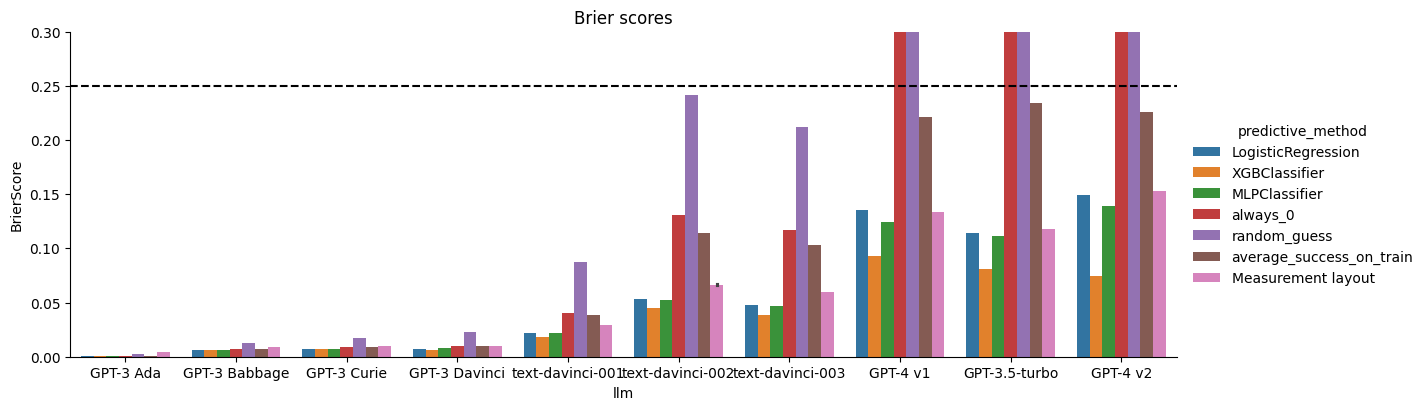

In [ ]:
sns.catplot(x="llm", y="BrierScore", hue="predictive_method", data=predictive_methods_df, kind="bar", height=4, aspect=3)
# set the ylim
plt.ylim(0, .3)
plt.axhline(y=0.25, color='black', linestyle='--')
plt.title("Brier scores")

Text(0.5, 1.0, 'AUROC')

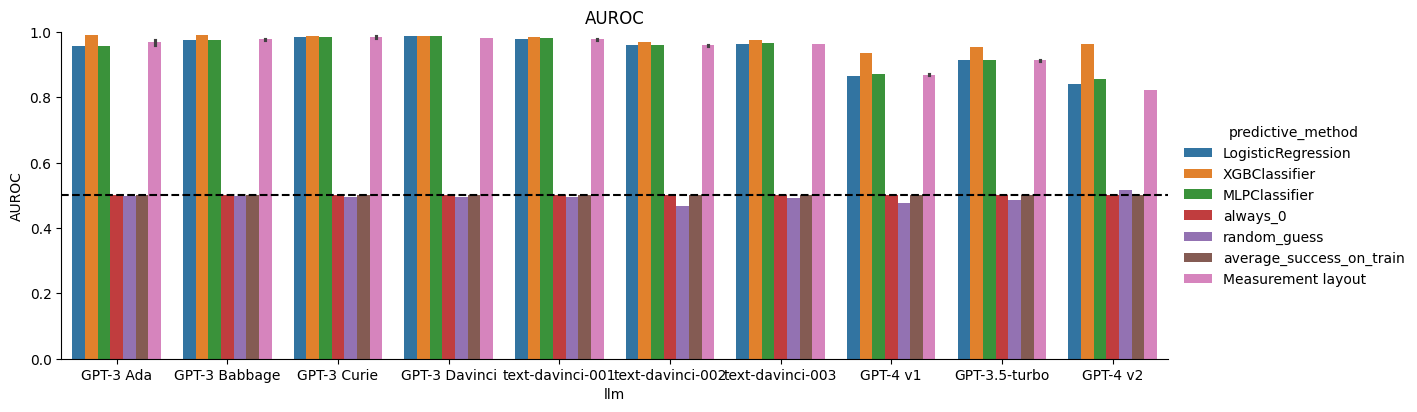

In [ ]:
sns.catplot(x="llm", y="AUROC", hue="predictive_method", data=predictive_methods_df, kind="bar", height=4, aspect=3)
# set the ylim
plt.ylim(0, 1)
plt.axhline(y=0.5, color='black', linestyle='--')
plt.title("AUROC")